# This notebook is dedicated to the integration of XAI technologies to the state-of-the art models
### MSC/DSA/134

In [1]:
# import required packages
import joblib
import globals.data_utils as data_utils
import lime.lime_tabular
from globals.pandas_functions import *
import globals.explainers.shap_explainer as shap_explainer
import globals.explainers.lime_explainer as lime_explainer

C:\Users\PM User\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# define base path
root_path = "data/processed/null_value_option_1_with_validation_set"

In [3]:
# get feature names
feature_names_json = root_path + "/dataset_feature_names.json"

import json
with open(feature_names_json, 'r') as f:
    feature_names = json.load(f)

print("Feature names loaded:")
print(feature_names)


Feature names loaded:
['TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'card4', 'card6', 'P_emaildomain', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'M4', 'M1_T', 'M2_T', 'M3_T', 'M6_T']


In [4]:
# import evaluation functions
from globals.model_evaluations import (
    evaluate_accuracy, evaluate_precision, evaluate_recall,
    evaluate_f1_score, evaluate_roc_auc
)
from sklearn.metrics import roc_auc_score, average_precision_score

In [5]:
# define fitted models path
fitted_models_base = "models/state_of_the_art/"

In [6]:
# without PCA selected features
data_base_path = root_path + "/scaled_and_balanced"


X_train = pd.read_csv(f"{data_base_path}/unified_transaction_data_option2_x_train_balanced.csv")
X_validation = pd.read_csv(f"{data_base_path}/unified_transaction_data_option2_x_validation_scaled.csv")
X_test = pd.read_csv(f"{data_base_path}/unified_transaction_data_option2_x_test_scaled.csv")

y_train = pd.read_csv(f"{data_base_path}/unified_transaction_data_option2_y_train_balanced.csv")
y_validation = pd.read_csv(f"{data_base_path}/unified_transaction_data_option2_y_validation.csv")
y_test = pd.read_csv(f"{data_base_path}/unified_transaction_data_option2_y_test.csv")

In [7]:
dataset_dimension("X_train", X_train)
dataset_dimension("X_test", X_test)

X_train dataset dimension: (683822, 26)
X_test dataset dimension: (118102, 26)


In [8]:
# view class distributions
data_utils.show_class_distribution(X_train, y_train.to_numpy().ravel(), "Class distribution of original dataset")
data_utils.show_class_distribution(X_test, y_test.to_numpy().ravel(), "Class distribution of test dataset")


Class distribution of original dataset:
  Total samples: 683822
  Y df samples:  [0 0 0 ... 1 1 1]
  Class 0 (non-fraud): 341911 (50.00%)
  Class 1 (fraud): 341911 (50.00%)

Class distribution of test dataset:
  Total samples: 118102
  Y df samples:  [0 0 1 ... 0 0 0]
  Class 0 (non-fraud): 113971 (96.50%)
  Class 1 (fraud): 4131 (3.50%)


## 1. SVM Model

In [7]:
# 01. SVM Model with XAI Integration

# load SVM model
svm_model = joblib.load(fitted_models_base + "svm_linear_model.joblib")

In [8]:
# make predictions and get probabilities for evaluation
y_pred = svm_model.predict(X_test.to_numpy())
y_pred_probability = svm_model.predict_proba(X_test.to_numpy())

In [11]:
# comprehensive SVM evaluation metrics
y_test_flat = y_test.to_numpy().ravel()
y_pred_proba_pos = y_pred_probability[:, 1]

print("="*50)
print("SVM MODEL EVALUATION")
print("="*50)

# basic metrics
svm_acc = evaluate_accuracy(y_test_flat, y_pred)
svm_prec = evaluate_precision(y_test_flat, y_pred, average="binary")
svm_rec = evaluate_recall(y_test_flat, y_pred, average="binary")
svm_f1 = evaluate_f1_score(y_test_flat, y_pred, average="binary")

# auc metrics
svm_auroc = roc_auc_score(y_test_flat, y_pred_proba_pos)
svm_auprc = average_precision_score(y_test_flat, y_pred_proba_pos)

print(f"AUROC: {svm_auroc:.4f}")
print(f"AUPRC: {svm_auprc:.4f}")

print(f"\nSummary Metrics:")
print(f"  Accuracy:  {svm_acc:.4f}")
print(f"  Precision: {svm_prec:.4f}")
print(f"  Recall:    {svm_rec:.4f}")
print(f"  F1 Score:  {svm_f1:.4f}")
print(f"  AUROC:     {svm_auroc:.4f}")
print(f"  AUPRC:     {svm_auprc:.4f}")

SVM MODEL EVALUATION
Accuracy: 0.9659 (96.59%)
Precision (binary): 0.9569
Recall (binary): 0.0269
F1-Score (binary): 0.0523
AUROC: 0.6838
AUPRC: 0.2699

Summary Metrics:
  Accuracy:  0.9659
  Precision: 0.9569
  Recall:    0.0269
  F1 Score:  0.0523
  AUROC:     0.6838
  AUPRC:     0.2699


In [9]:
# set XAI meta data
test_for_fraud = 1
interpretability_index = y_test.index[y_test["isFraud"] == test_for_fraud][0]
y_instance = y_test.loc[interpretability_index]
print(f"search index: {interpretability_index} \ny_instance: {y_instance}")

search index: 2 
y_instance: isFraud    1
Name: 2, dtype: int64


### 1.1. SVM - SHAP Integration

In [10]:
shap = shap_explainer.SHAPExplainer(svm_model, X_train, X_test, feature_names, "svm")
shap.explain()

Initialized SHAPExplainer:
  Model type: svm
  Explainer type: kernel
  Features: 26



Computing SHAP Explanations for SVM
Using KERNEL Explainer
Creating KernelExplainer...
  ✓ Using 100 background samples
  ⚠ This is slower but works with any model

✓ Explainer initialization time: 0.06 seconds

Calculating SHAP values for 20 test samples...


100%|██████████| 20/20 [09:50<00:00, 29.54s/it]

✓ SHAP values computation time: 590.87 seconds
  SHAP values shape: (20, 26, 2)



Generating SHAP Summary Plot (Bar)...


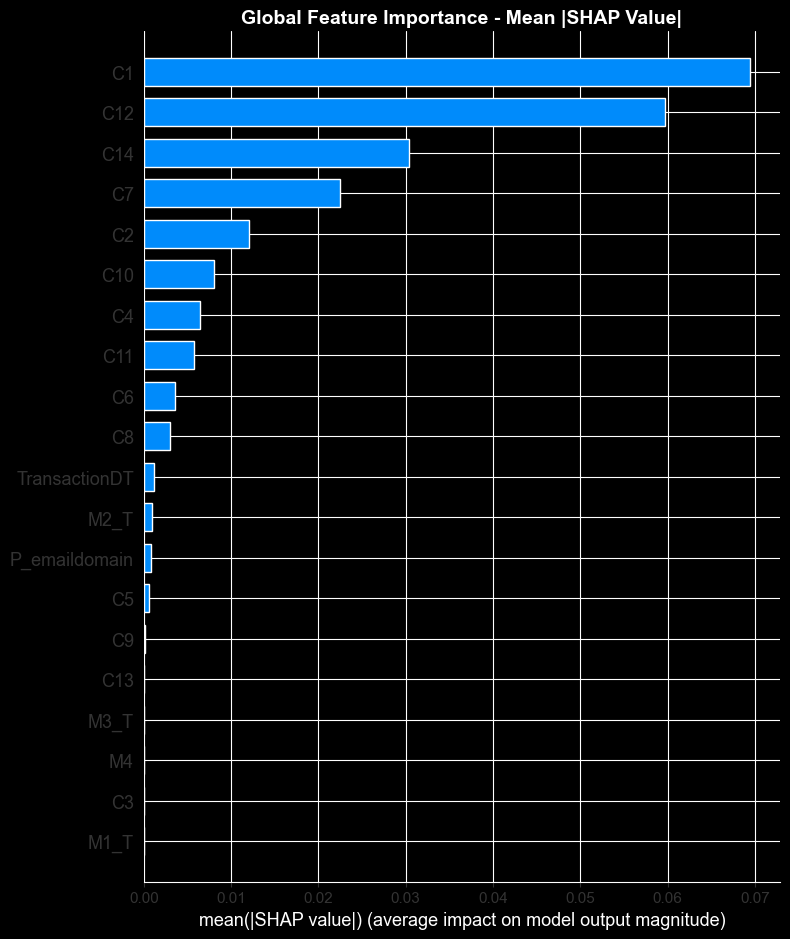

Generating SHAP Summary Plot (Dot)...


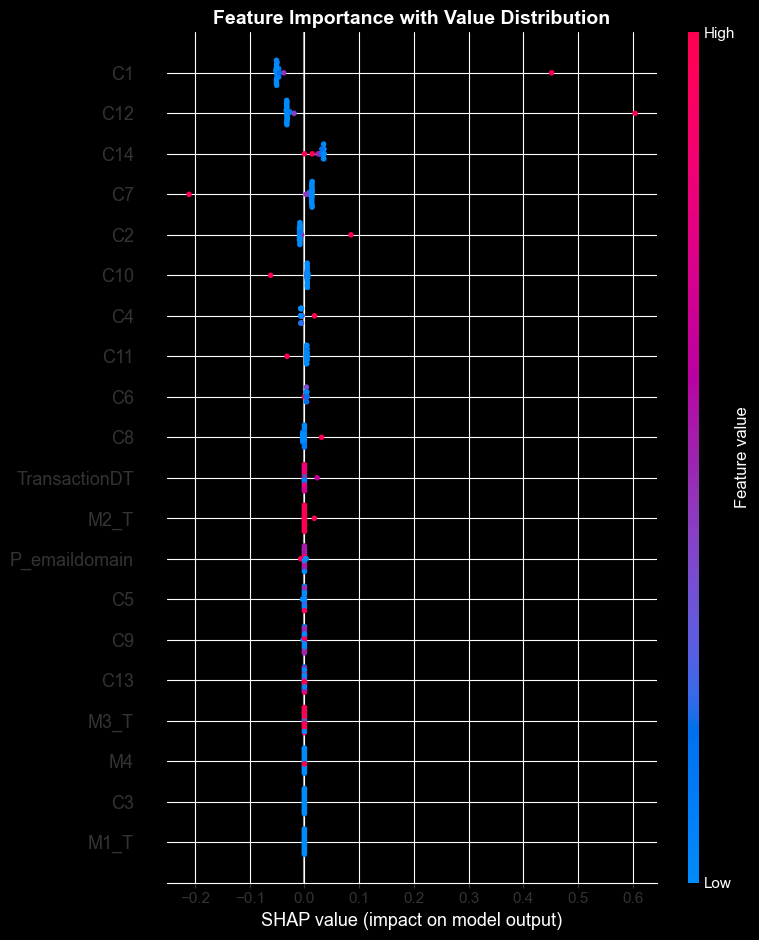

In [11]:
# show SHAP summary plot for global feature importance
shap.show_global_summary_plots()


SHAP Force Plot for Instance 2

Extracting SHAP values for instance 2:
  Base value (expected): 0.0725
  SHAP values shape: (26,)
  Sum of SHAP values: 0.9275
  Prediction: 1.0000


<Figure size 2000x300 with 0 Axes>

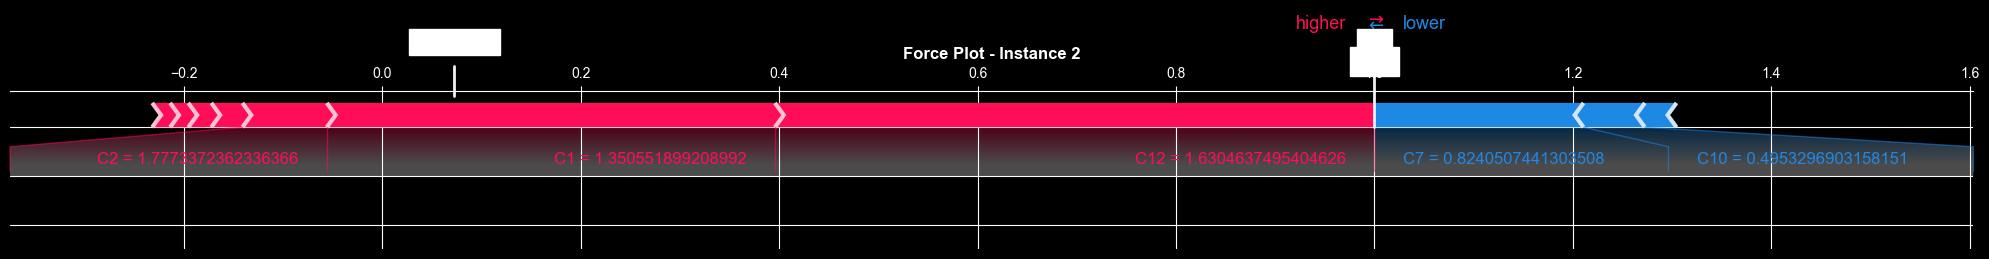

In [12]:
# show SHAP force plot for the specific instance
shap.show_local_interpretability(interpretability_index)


SHAP Waterfall Plot for Instance 2

Extracting SHAP values for instance 2:
  Base value (expected): 0.0725
  SHAP values shape: (26,)
  Sum of SHAP values: 0.9275
  Prediction: 1.0000


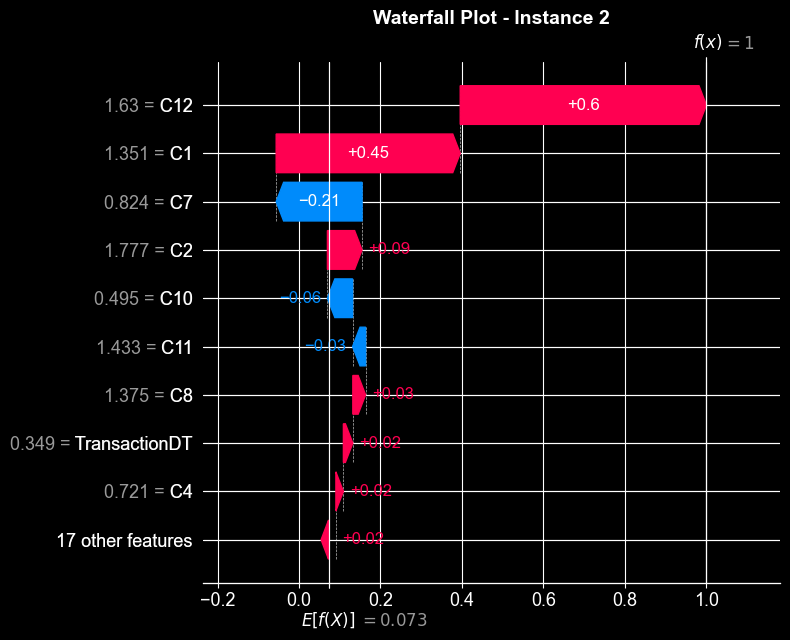

In [14]:
# show waterfall plot for the specific instance
shap.show_waterfall_plot(interpretability_index)

In [13]:
# get feature importance of the specific instance

# export shap values
xai_results_path = "xai_outputs/state_of_the_art/"
file_name = "svm_shap_result.csv"

shap.get_feature_influence(interpretability_index,xai_results_path, file_name)
# todo: fix issues here


Detailed Feature Influences for Instance 2

Extracting SHAP values for instance 2:
  Base value (expected): 0.0725
  SHAP values shape: (26,)
  Sum of SHAP values: 0.9275
  Prediction: 1.0000

Top 15 Most Influential Features:
Dataset Feature Index  Feature Name  Feature Value  SHAP Value (Influence)
                   18           C12       1.630464                0.604306
                    7            C1       1.350552                0.451705
                   13            C7       0.824051               -0.210836
                    8            C2       1.777337                0.085079
                   16           C10       0.495330               -0.061830
                   17           C11       1.433082               -0.031902
                   14            C8       1.374608                0.031359
                    0 TransactionDT       0.349459                0.023145
                   10            C4       0.720849                0.018386
                   23 

,Dataset Feature Index,Feature Name,Feature Value,SHAP Value (Influence)
18,18,C12,1.630464,0.604306
7,7,C1,1.350552,0.451705
13,13,C7,0.824051,-0.210836
8,8,C2,1.777337,0.085079
16,16,C10,0.495330,-0.061830
17,17,C11,1.433082,-0.031902
14,14,C8,1.374608,0.031359
0,0,TransactionDT,0.349459,0.023145
10,10,C4,0.720849,0.018386
23,23,M2_T,0.245822,0.018065


### 1.2. SVM - LIME Integration

In [15]:
# Create LIME Explainer
lime = lime_explainer.LimeExplainer(X_train,X_test, feature_names, svm_model.predict_proba)
lime.init_lime_explainer()

Generating LIME Explainer...
LIME Explainer initialization time: 3.39 seconds


Explaining instance 2 with LIME...
LIME explanation computation time: 0.64 seconds
LIME Explanation Plot:


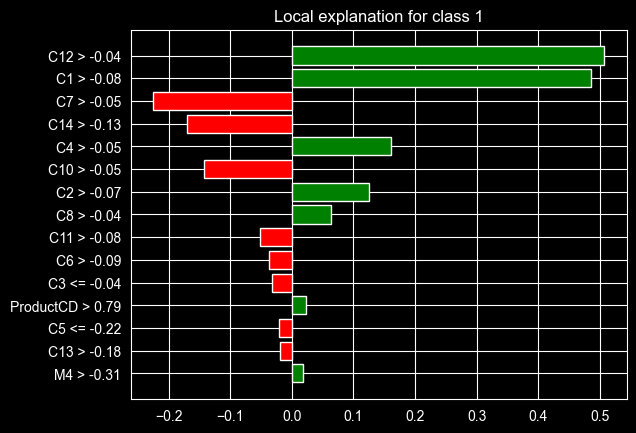

In [16]:
# Show LIME explanation in notebook (HTML)
lime.show_lime_explainer(interpretability_index, 15)

## 2. XGBoost Model

### 2.1. XGBoost - SHAP Integration

### 2.1. XGBoost - LIME Integration